In [1]:
from tropycal import realtime

# DataSource: UCAR
This datasource

In [2]:
realtime_obj = realtime.Realtime(jtwc=True, jtwc_source='ucar')

--> Starting to read in current storm data
--> Completed reading in current storm data (111.28 seconds)


In [3]:
active_storms = realtime_obj.list_active_storms()
active_storms

['AL132023', 'AL142023', 'AL972023', 'EP942023']

Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #1 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but w

<GeoAxes: title={'left': 'Summary & NHC 7-Day Formation Outlook', 'right': 'Valid: 02 UTC 15 Sep 2023'}>

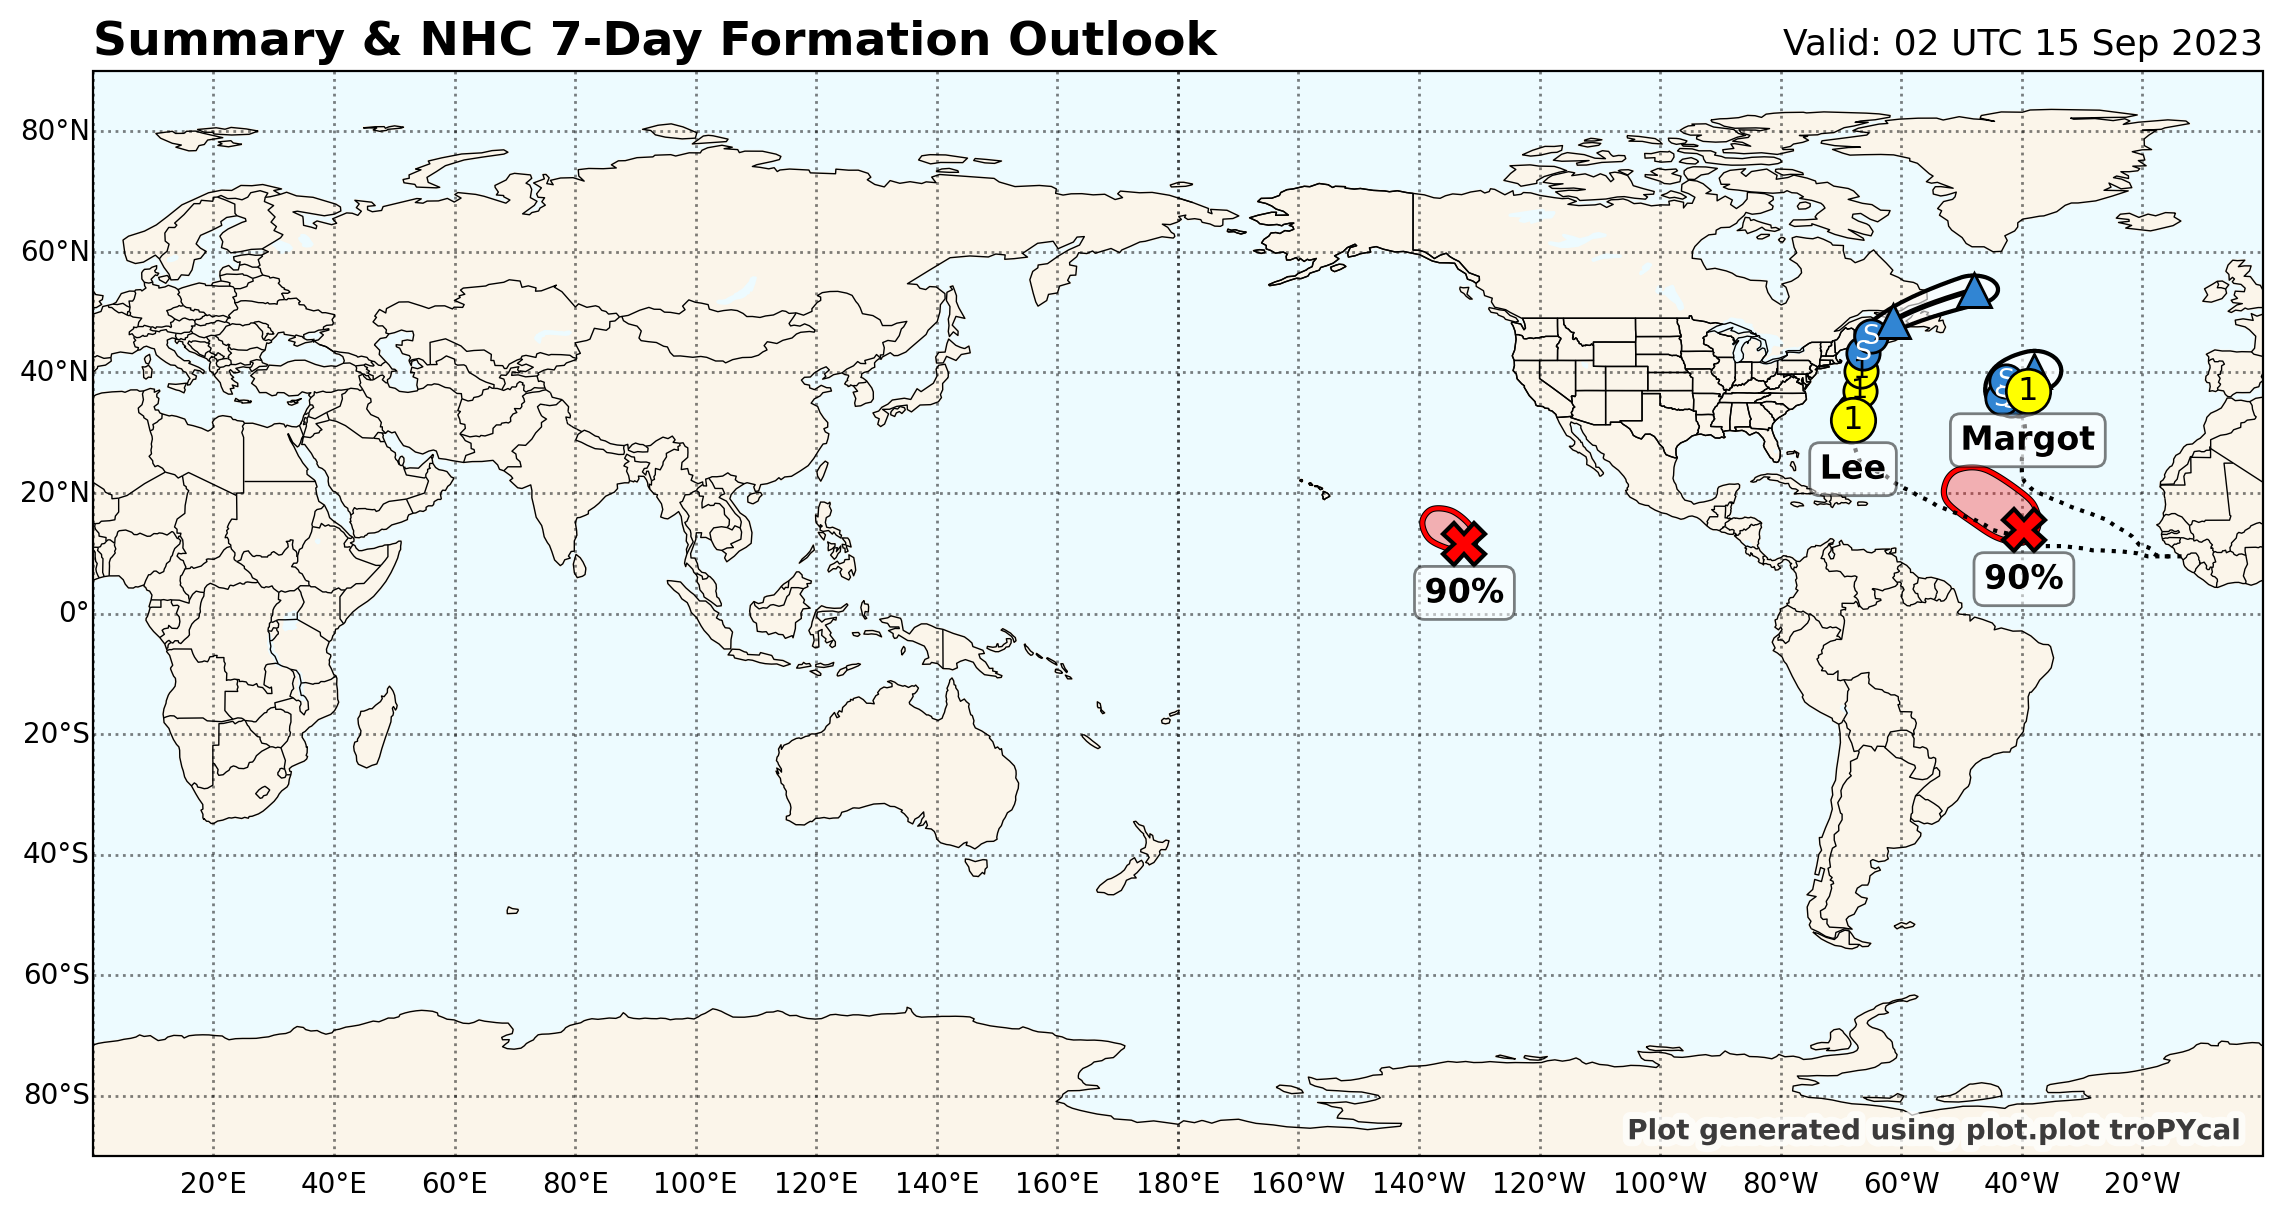

In [4]:
realtime_obj.plot_summary()

Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #1 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but w

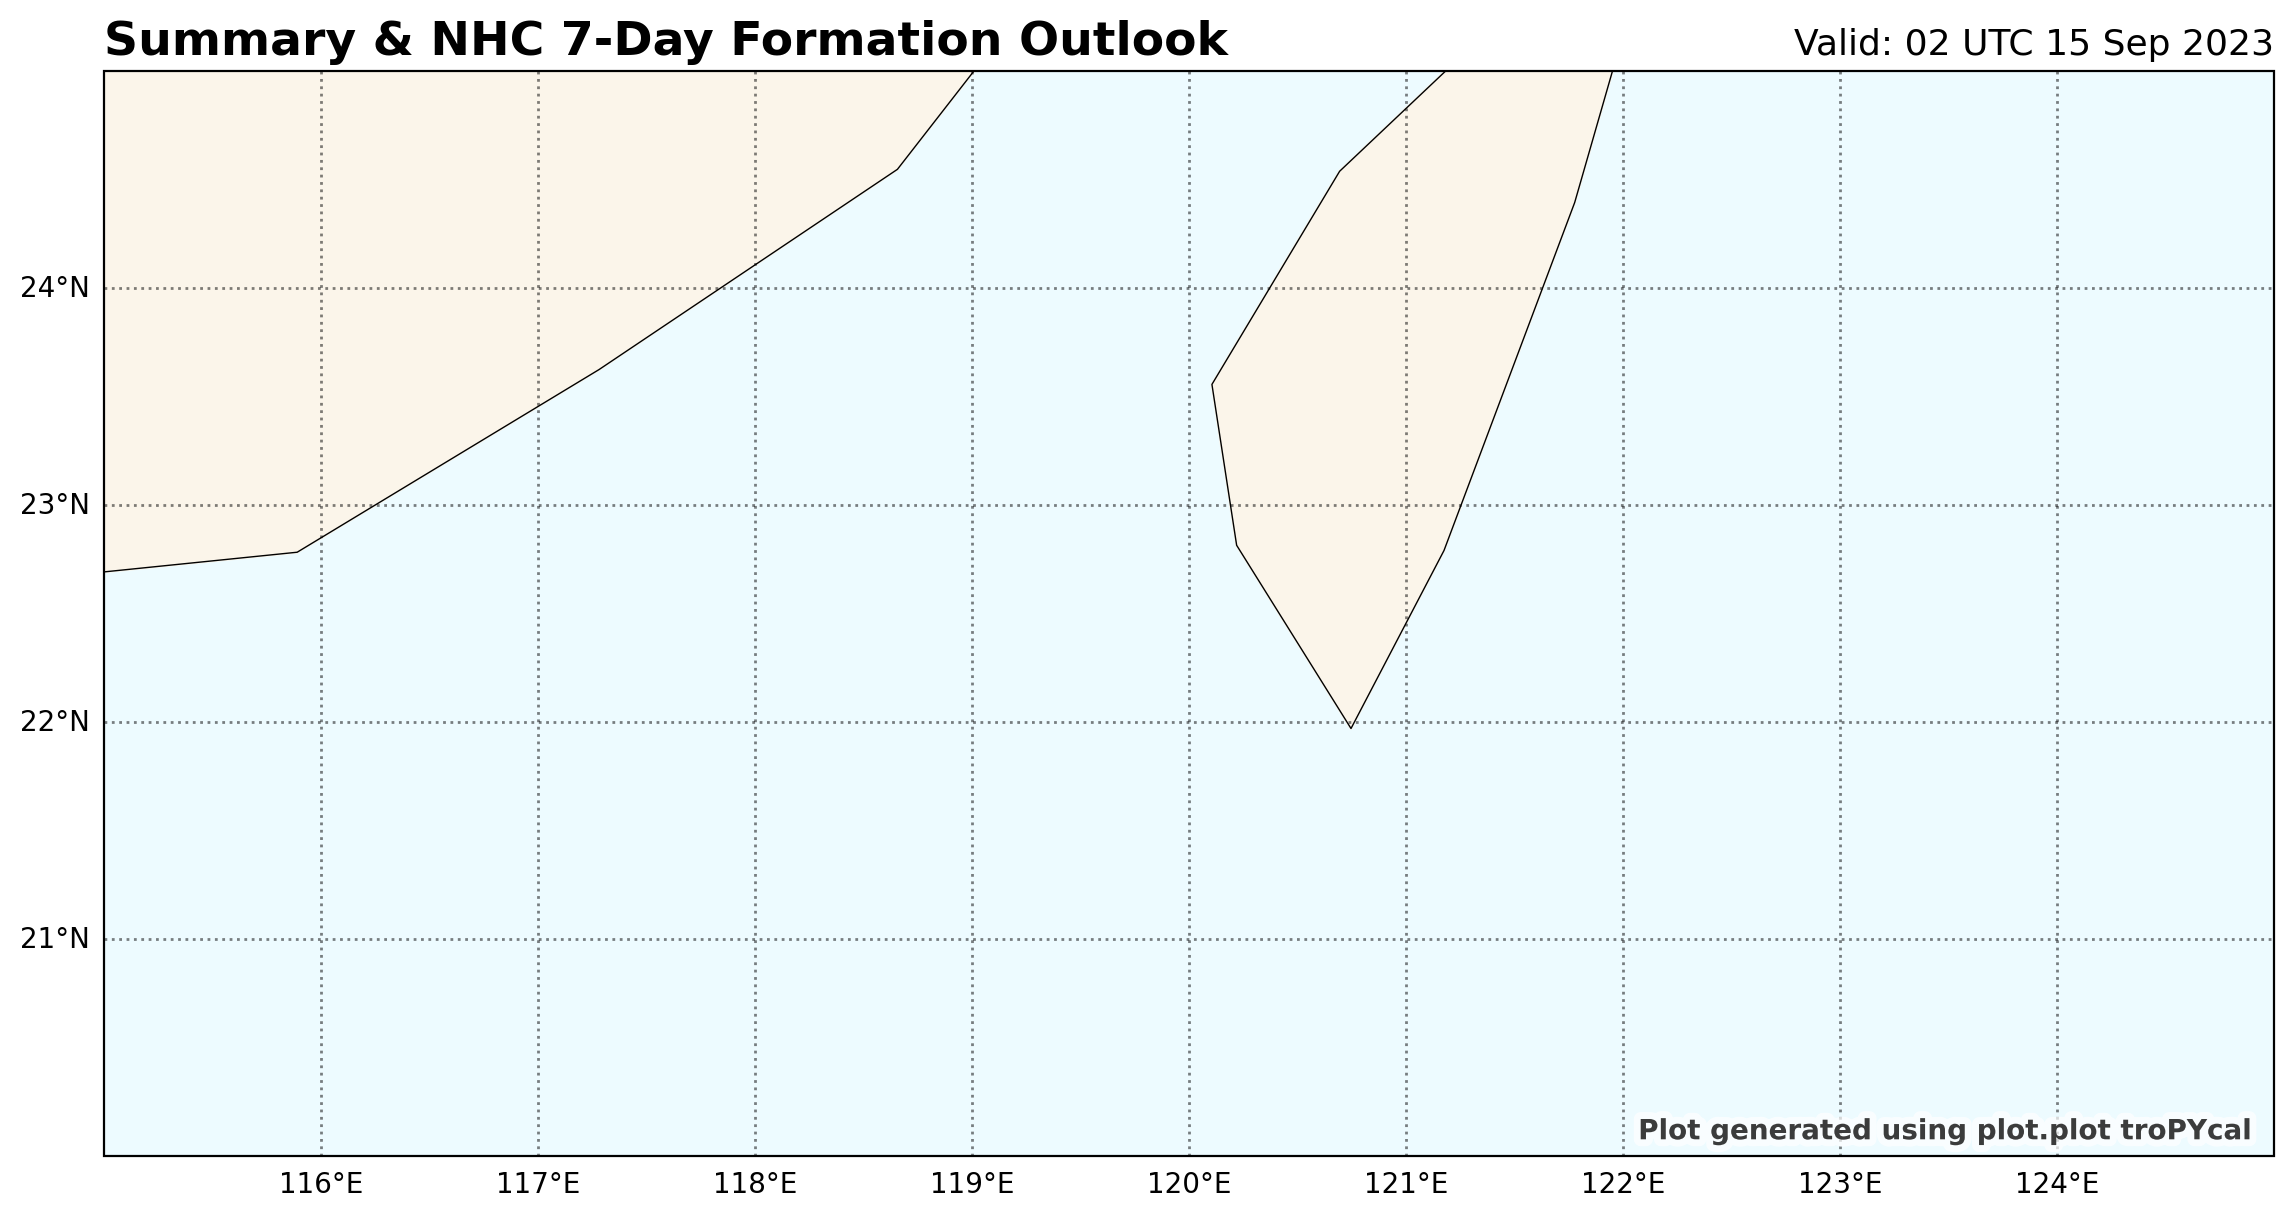

In [5]:
tw_domain = {'w':115,'e':125,'s':20,'n':25}
p = realtime_obj.plot_summary(domain=tw_domain)

In [6]:
storm = realtime_obj.get_storm(active_storms[0])


In [7]:
forecasts = storm.get_operational_forecasts()


In [8]:
storm_forecast = storm.get_forecast_realtime(ssl_certificate=False)

In [9]:
forecasts['HWRF'].keys()

dict_keys(['2023090300', '2023090306', '2023090312', '2023090318', '2023090400', '2023090406', '2023090412', '2023090418', '2023090500', '2023090506', '2023090512', '2023090518', '2023090600', '2023090606', '2023090612', '2023090618', '2023090700', '2023090706', '2023090712', '2023090718', '2023090800', '2023090806', '2023090812', '2023090818', '2023090900', '2023090906', '2023090912', '2023090918', '2023091000', '2023091006', '2023091012', '2023091018', '2023091100', '2023091106', '2023091112', '2023091118', '2023091200', '2023091206', '2023091212', '2023091218', '2023091300', '2023091306', '2023091312', '2023091318', '2023091400', '2023091406', '2023091412'])

In [10]:
my_models = models_dict = {
    #"GFSO": "Global Forecast System Operational",
    "HWRF": "Hurricane Weather Research and Forecasting Model",
    "UKX": "UK Met Office Model",
    #"NAM": "North American Mesoscale Forecast System",
    "CMC": "Canadian Meteorological Centre",
    "HMON": "Hurricanes in a Multi-scale Ocean-coupled Non-hydrostatic Model",
    "ICON": "Icosahedral Nonhydrostatic Model"
}

for model in my_models.keys():
    forecasts[model][max(forecasts[model].keys())]

In [11]:
lats = storm['lat'].tolist() + storm_forecast['lat']
lons = storm['lon'].tolist() + storm_forecast['lon']

storm_s = min(lats) - 5
storm_n = max(lats) + 5
storm_w = max(lons) + 5
storm_e = min(lons) - 5
storm_box = (storm_w, storm_e, storm_s, storm_n)
storm_box

(-8.5, -73.4, 4.5, 58.7)

In [12]:
def get_df(storm):
    storm_df = storm.to_dataframe()
    by_hour = 12
    days_ago = 5
    past_date = datetime.datetime.utcnow() - datetime.timedelta(days=days_ago)
    storm_df["should_plot_step"] = (storm_df['time'] >= past_date) & (storm_df['time'].dt.hour / by_hour ==0)
    storm_df['name'] = storm['name']
    return storm_df
storm_df = get_df(storm)
storm_df

NameError: name 'datetime' is not defined

In [ ]:
a = storm.plot_forecast_realtime(ssl_certificate=False, prop={'ms':10, 'cone_lw':2})

In [ ]:
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy.mpl.ticker import LatitudeFormatter, LatitudeLocator, LongitudeFormatter
from matplotlib.pyplot import Axes

from models import StormForecasts


def get_my_recent_forecasts(
    storm_id: str, tropycal_forecasts: realtime.Realtime, hafs_storms: StormForecasts
) -> StormForecasts:
    my_storm_forecasts = StormForecasts()

    lower_storm_id = storm_id[2:4] + storm_id[1:2].lower()
    tropycal_most_recent_forecasts = []
    for key in tropycal_forecasts.keys():
        my_dict = {}
        most_recent_time = max(tropycal_forecasts[key].keys())
        my_date = datetime.datetime.strptime(most_recent_time[0:8], "%Y%m%d")
        my_hour = most_recent_time[-2:]
        my_dict["fhr"] = tropycal_forecasts[key][most_recent_time]["fhr"]
        my_dict["lat"] = tropycal_forecasts[key][most_recent_time]["lat"]
        my_dict["lon"] = tropycal_forecasts[key][most_recent_time]["lon"]
        my_dict["wind_kt"] = tropycal_forecasts[key][most_recent_time]["vmax"]
        my_forecast = StormForecast(
            storm_id=lower_storm_id,
            model_id=key,
            forecast_date=my_date,
            forecast_hour=my_hour,
            dataframe=pd.DataFrame(my_dict),
        )
        tropycal_most_recent_forecasts.append(my_forecast)

    hafs_forecasts = [
        x for x in hafs_storms.forecasts if x["storm_id"] == lower_storm_id
    ]
    my_storm_forecasts.forecasts.extend(hafs_forecasts)
    my_storm_forecasts.forecasts.extend(tropycal_most_recent_forecasts)
    return my_storm_forecasts


def get_colors_sshws(wind_speed: int) -> str:
    r"""
    Retrieve the default colors for the Saffir-Simpson Hurricane Wind Scale (SSHWS).

    Parameters
    ----------
    wind_speed : int or list
        Sustained wind speed in knots.

    Returns
    -------
    str
        Hex string for the corresponding color.
    """

    # # If category string passed, convert to wind
    # if isinstance(wind_speed, str):
    #     wind_speed = category_label_to_wind(wind_speed)

    # Return default SSHWS category color scale
    if wind_speed < 5:
        return "#FFFFFF"
    elif wind_speed < 34:
        return "#8FC2F2"  # '#7DB7ED'
    elif wind_speed < 64:
        return "#3185D3"
    elif wind_speed < 83:
        return "#FFFF00"
    elif wind_speed < 96:
        return "#FF9E00"
    elif wind_speed < 113:
        return "#DD0000"
    elif wind_speed < 137:
        return "#FF00FC"
    else:
        return "#8B0088"


def get_plot_box(
    lats: list[float], lons: list[float]
) -> tuple[tuple[float, float, float, float], float, float]:
    storm_s = min(lats)
    storm_n = max(lats)
    storm_w = max(lons)
    storm_e = min(lons)
    # storm_box = (storm_w, storm_e, storm_s, storm_n)
    storm_width = abs(storm_e - storm_w)
    storm_height = abs(storm_s - storm_n)

    central_lon = (storm_w + storm_e) / 2
    central_lat = (storm_n + storm_s) / 2

    padding_vertical = storm_height / 4
    padding_horizontal = storm_width / 4

    # If same then it is a box
    plot_height = storm_height
    plot_width = storm_height * 2

    plot_n = (central_lat + plot_height / 2) + padding_vertical
    plot_s = (central_lat - plot_height / 2) - padding_vertical
    plot_e = (central_lon + plot_width / 2) + padding_horizontal
    plot_w = (central_lon - plot_width / 2) - padding_horizontal
    plot_box = (plot_w, plot_e, plot_s, plot_n)
    return plot_box, central_lat, central_lon


def add_annotation_pointers(ax: Axes, fhr: float, xy: tuple[float, float]) -> None:
    ax.annotate(
        text=str(fhr),
        xy=xy,
        xycoords="data",
        xytext=(20, 20),
        textcoords="offset points",
        fontweight="bold",
        ha="center",
        va="center",
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            connectionstyle="arc3",
            color="k",
        ),
        transform=ccrs.PlateCarree(),
        clip_on=True,
        zorder=1,
    )


def add_background_maps(ax: Axes) -> None:
    # Plot coastlines and political boundaries
    ax.add_feature(
        cfeature.STATES.with_scale("50m"),
        linewidths=0.1,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )

    # Fill in continents in light gray
    ax.add_feature(
        cfeature.LAND.with_scale("50m"), facecolor=land_color, edgecolor="face"
    )
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"), facecolor=water_color, edgecolor="face"
    )


def add_grid_lines(ax: Axes) -> None:
    axes_label_style = {"size": 12, "color": "black"}
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.left_labels = False
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.ylabel_style = axes_label_style
    gl.xlabel_style = axes_label_style


def plot_storm(tropycal_storm_df: pd.DataFrame, storm_forecast: dict) -> plt.figure:
    storm_forecast["already_forcasted"] = [
        (datetime.timedelta(hours=x) + storm_forecast["init"])
        <= tropycal_storm_df.time.max()
        for x in storm_forecast["fhr"]
    ]

    fig, ax = plot_base(tropycal_storm_df, storm_forecast)

    ax.set_title(
        "DEVELOPING STORM: " + tropycal_storm_df["name"].values[0],
        loc="left",
        # fontsize=25,
        fontweight="bold",
    )
    ax.legend(handles=[td, ts, c1, c2, c3, c4, c5], prop={"size": 7.5})

    # Plot historical (already happened) Dots
    storm_line_x = []
    storm_line_y = []
    for i in range(0, len(tropycal_storm_df["lat"])):
        if not tropycal_storm_df["should_plot_step"][i]:
            continue
        ax.plot(
            tropycal_storm_df["lon"][i],
            tropycal_storm_df["lat"][i],
            transform=ccrs.PlateCarree(),
            linewidth=2,
            marker="o",
            markersize=marker_size,
            color=get_colors_sshws(np.nan_to_num(tropycal_storm_df["vmax"][i])),
            zorder=2,
        )
        storm_line_x.append(tropycal_storm_df["lon"][i])
        storm_line_y.append(tropycal_storm_df["lat"][i])

    # Plot Already happened Line
    ax.plot(
        storm_line_x,
        storm_line_y,
        transform=ccrs.PlateCarree(),
        linewidth=1,
        color="gray",
        zorder=1,
    )

    # Forecast Dots
    for i in range(0, len(storm_forecast["lat"])):
        if storm_forecast["already_forcasted"][i]:
            continue

        fhr = storm_forecast["fhr"][i]
        x = storm_forecast["lon"][i]
        y = storm_forecast["lat"][i]

        ax.plot(
            x,
            y,
            transform=ccrs.PlateCarree(),
            marker="o",
            color=get_colors_sshws(np.nan_to_num(storm_forecast["vmax"][i])),
            markersize=marker_size,
            zorder=2,
        )
        # Lables for hrs after forecast
        if not fhr % 24 == 0:
            continue
        add_annotation_pointers(ax, fhr=fhr, xy=(x, y))

    fig.tight_layout()
    ax.set_aspect("auto")

    return fig


def plot_base(
    storm: pd.DataFrame, storm_forecast: pd.DataFrame | dict
) -> tuple[plt.figure, Axes]:
    if isinstance(storm_forecast, dict):
        forecast_lons = storm_forecast["lon"]
        forecast_lats = storm_forecast["lat"]
    else:
        forecast_lons = storm_forecast["lon"].tolist()
        forecast_lats = storm_forecast["lat"].tolist()

    lons = storm[storm["should_plot_step"]]["lon"].tolist() + forecast_lons
    lats = storm[storm["should_plot_step"]]["lat"].tolist() + forecast_lats

    plot_box, central_lat, central_lon = get_plot_box(lats, lons)

    fig = plt.figure(dpi=400)

    ax = plt.axes(
        projection=ccrs.Orthographic(
            central_longitude=central_lon, central_latitude=central_lat
        )
    )

    add_background_maps(ax)

    add_grid_lines(ax)
    ax.set_extent(plot_box, crs=ccrs.PlateCarree())

    add_background_maps(ax)

    return fig, ax


def plot_compare_forecasts(
    storm_id: str,
    tropycal_storm_df: pd.DataFrame,
    tropycal_forecasts,
    hafs_storms,
) -> plt.figure:
    my_storm_forecasts = get_my_recent_forecasts(
        storm_id, tropycal_forecasts=tropycal_forecasts, hafs_storms=hafs_storms
    )

    example_forecast = [
        x for x in my_storm_forecasts.forecasts if x.model_id == "HWRF"
    ][0].dataframe

    fig, ax = plot_base(tropycal_storm_df, example_forecast)

    ax.set_title(
        "DEVELOPING STORM: " + tropycal_storm_df["name"].values[0],
        loc="left",
        # fontsize=25,
        fontweight="bold",
    )

    # Plot historical (already happened) Dots
    for i in range(0, len(tropycal_storm_df["lat"])):
        if not tropycal_storm_df["should_plot_step"][i]:
            continue
        ax.plot(
            tropycal_storm_df["lon"][i],
            tropycal_storm_df["lat"][i],
            transform=ccrs.PlateCarree(),
            linewidth=2,
            marker="o",
            markersize=marker_size,
            color=get_colors_sshws(np.nan_to_num(tropycal_storm_df["vmax"][i])),
            zorder=2,
        )

    # Plot Already happened Line
    ax.plot(
        tropycal_storm_df["lon"].tolist(),
        tropycal_storm_df["lat"].tolist(),
        transform=ccrs.PlateCarree(),
        linewidth=1,
        color="gray",
        zorder=1,
    )

    # Forecast Lines
    models_to_plot = [
        x for x in my_storm_forecasts.forecasts if x.model_id in my_models.keys()
    ]
    for mycast in models_to_plot:
        model = mycast.model_id
        storm_forecast = mycast.dataframe

        if storm_forecast.empty:
            continue

        mydt = datetime.datetime.combine(
            mycast.forecast_date, datetime.time(hour=int(mycast.forecast_hour))
        )

        storm_forecast["already_forecasted"] = [
            (datetime.timedelta(hours=x) + mydt) < tropycal_storm_df.time.max()
            for x in storm_forecast["fhr"].tolist()
        ]

        storm_forecast = storm_forecast[~storm_forecast["already_forecasted"]]

        ax.plot(
            storm_forecast["lon"],
            storm_forecast["lat"],
            transform=ccrs.PlateCarree(),
            linewidth=1,
            color=my_models[model][
                "color"
            ],  # use the color from the dictionary, default to black if not found
            zorder=1,
            label=model,
        )
    ax.legend(loc="upper right", prop={"size": 15})
    fig.tight_layout()
    ax.set_aspect("auto")
    return fig


cone_color = "#fffde6"
cone_color = "#e6f2ff"
cone_color = "#fff8d5"
water_color = "#d5f0ff"
land_color = "#fcf3e8"
land_scale = "50m"
marker_size = 10


legend_size = 7

ex = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Non-Tropical",
    marker="^",
    color="w",
)
sb = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Subtropical",
    marker="s",
    color="w",
)
uk = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Unknown",
    marker="o",
    color="w",
)
td = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Depression",
    marker="o",
    color=get_colors_sshws(33),
)
ts = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Storm",
    marker="o",
    color=get_colors_sshws(34),
)
c1 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 1",
    marker="o",
    color=get_colors_sshws(64),
)
c2 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 2",
    marker="o",
    color=get_colors_sshws(83),
)
c3 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 3",
    marker="o",
    color=get_colors_sshws(96),
)
c4 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 4",
    marker="o",
    color=get_colors_sshws(113),
)
c5 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 5",
    marker="o",
    color=get_colors_sshws(137),
)

my_cone = {
    0: 0,
    12: 16,
    24: 26,
    36: 39,
    48: 53,
    60: 67,
    72: 81,
    96: 99,
    108: 145,
    120: 205,
}

my_models = {
    "HWRF": {
        "name": "Hurricane Weather Research and Forecasting Model",
        "color": "#1f77b4",  # muted blue
    },
    "AVNO": {"name": "GFS", "color": "#ff7f0e"},  # safety orange
    "CMC": {
        "name": "Canadian Meteorological Centre",
        "color": "#2ca02c",  # cooked asparagus green
    },
    "NVGM": {
        "name": "NVGM",
        "color": "#d62728",  # brick red
    },
    "ICON": {
        "name": "Icosahedral Nonhydrostatic Model",
        "color": "#9467bd",  # muted purple
    },
    "hfsa": {
        "name": "HAFS 1a",
        "color": "#e377c2",  # pink
    },
    "hfsb": {
        "name": "HAFS 1b",
        "color": "#bcbd22",  # yellowish-green
    },
}


# fig = plot_storm(storm_df, storm_forecast)
# fig.show()

# fig = plot_all_forecasts(storm_df, forecasts)
# fig.show()


In [ ]:
fig.savefig(f"TEST_myimage2.jpg")

In [101]:
storm_df

,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin,should_plot_step
0,2023-09-01 12:00:00,0,,DB,9.5,-13.5,20,1011,north_atlantic,False
1,2023-09-01 18:00:00,0,,DB,9.5,-14.8,20,1011,north_atlantic,False
2,2023-09-02 00:00:00,0,,DB,9.5,-16.3,20,1011,north_atlantic,False
3,2023-09-02 06:00:00,0,,DB,9.5,-17.8,20,1011,north_atlantic,False
4,2023-09-02 12:00:00,0,,DB,9.5,-19.1,25,1010,north_atlantic,False
5,2023-09-02 18:00:00,0,,DB,10.0,-20.8,30,1010,north_atlantic,False
6,2023-09-03 00:00:00,0,,DB,10.3,-23.3,25,1010,north_atlantic,False
7,2023-09-03 06:00:00,0,,DB,10.4,-25.4,25,1010,north_atlantic,False
8,2023-09-03 12:00:00,0,,DB,10.5,-27.0,30,1010,north_atlantic,False
9,2023-09-03 18:00:00,0,,DB,10.5,-28.3,30,1010,north_atlantic,False


In [ ]:



# Put a background image on for nice sea rendering.
# ax.stock_img()
from matplotlib.offsetbox import AnchoredText
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
def main():
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1,projection=ccrs.Orthographic(central_latitude=-8, central_longitude=125))
    ax1.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())
    #ax = plt.axes(projection=ccrs.Orthographic())
    ax2 = fig.add_subplot(2, 2, 2,projection=ccrs.PlateCarree())
    ax2.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())


    # Put a background image on for nice sea rendering.
    ax1.stock_img()
    ax2.stock_img()


    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText('\u00A9 {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 12}, frameon=True)
    #ax1.add_artist(text)

    plt.show()

main()

In [ ]:
import numpy as np
def workaround_gridlines(src_proj, labels=True):
    # Workaround for plotting lines of constant latitude/longitude as gridlines
    # labels not supported for this projection.
    lats = np.linspace(-90, 90, num=181, endpoint=True)
    lons = np.linspace(0, 360, num=360, endpoint=False)

    yn = np.zeros(len(lats))
    lona = lons + yn.reshape(len(lats),1)
    cs2 = plt.contour(lons, lats, lona, 10, transform=src_proj, colors='b', linestyles='dashed')
    plt.clabel(cs2, fontsize=9, inline=True)

    yt = np.zeros(len(lons))
    lata = lats.reshape(len(lats),1) + yt
    cs = plt.contour(lons, lats, lata, 10, transform=src_proj, colors='r', linestyles='dashed')
    plt.clabel(cs, fontsize=9, inline=True)


def main():
    trgt_proj = ccrs.Orthographic(central_latitude=-90)
    src_proj = ccrs.PlateCarree()
    src_crs = ccrs.Geodetic()

    ax = plt.axes(projection=trgt_proj)
    ax.stock_img()

    ln = np.array([-179, 175])
    lt = np.array([-60, -65])

    # Plot gridlines
    workaround_gridlines(src_proj)

    ax.set_extent((ln.min(), ln.max(), lt.min(), lt.max()), crs=src_proj)
    ax.coastlines(resolution='110m', color='black', linewidth=0.5, zorder=1)

    plt.plot(ln, lt, '-k', transform=src_crs)
    plt.scatter(x=ln, y=lt, transform=src_crs)

    plt.show()
main()